In [77]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import hmean, gmean

#### Численное вычисление градиента и гессиана

In [78]:
def numerical_gradient(f, x, h=1e-5):
    x = np.asarray(x, dtype=float)
    grad = np.zeros_like(x)
    for i in range(len(x)):
        e = np.zeros_like(x)
        e[i] = 1.0
        grad[i] = (f(x + h*e) - f(x - h*e)) / (2*h)
    return grad

In [79]:
def numerical_hessian(f, x, h=1e-5):
    x = np.asarray(x, dtype=float)
    n = len(x)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            ei = np.zeros_like(x)
            ej = np.zeros_like(x)
            ei[i], ej[j] = 1.0, 1.0
            H[i, j] = (
                f(x + h*(ei + ej))
                - f(x + h*(ei - ej))
                - f(x - h*(ei - ej))
                + f(x - h*(ei + ej))
            ) / (4*h**2)
    return H

#### Аналитические и тестовые функции, зависимость ошибки от шага h

(a) Тригонометрическая функция

In [80]:
f1 = lambda x: np.sin(x[0]) + np.cos(2*x[0])
grad_f1 = lambda x: np.array([np.cos(x[0]) - 2*np.sin(2*x[0])])
hess_f1 = lambda x: np.array([[-np.sin(x[0]) - 4*np.cos(2*x[0])]])

(b) Многомерный полином

In [81]:
f2 = lambda x: x[0]**3 + x[1]**3 + x[2]**3 + 3*x[0]*x[1]*x[2]
def grad_f2(x):
    x0,x1,x2 = x
    return np.array([3*x0**2 + 3*x1*x2,
                     3*x1**2 + 3*x0*x2,
                     3*x2**2 + 3*x0*x1])
def hess_f2(x):
    x0,x1,x2 = x
    return np.array([[6*x0, 3*x2, 3*x1],
                     [3*x2, 6*x1, 3*x0],
                     [3*x1, 3*x0, 6*x2]])

(c) Композиция экспоненты, логарифма, арктангенса, возведения в степень

In [82]:
f3 = lambda x: np.exp(x[0])*np.log(x[1]) + np.arctan(x[0]**x[1]) - x[0]**x[1]
def grad_f3(x):
    x0,x1 = x
    df_dx = np.exp(x0)*np.log(x1) + x1*x0**(x1-1)/(1+x0**(2*x1)) - x1*x0**(x1-1)
    df_dy = np.exp(x0)/x1 + x0**x1*np.log(x0)/(1+x0**(2*x1)) - x0**x1*np.log(x0)
    return np.array([df_dx, df_dy])
hess_f3 = lambda x: numerical_hessian(f3, x)

In [83]:
points = {
    'f1': (f1, grad_f1, hess_f1, np.array([0.5])),
    'f2': (f2, grad_f2, hess_f2, np.array([1.0,2.0,-1.0])),
    'f3': (f3, grad_f3, hess_f3, np.array([1.2,2.3])),
}
hs = np.logspace(-8, -1, 50)

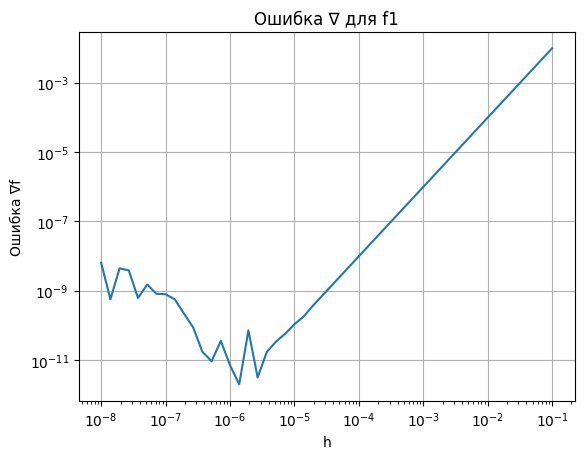

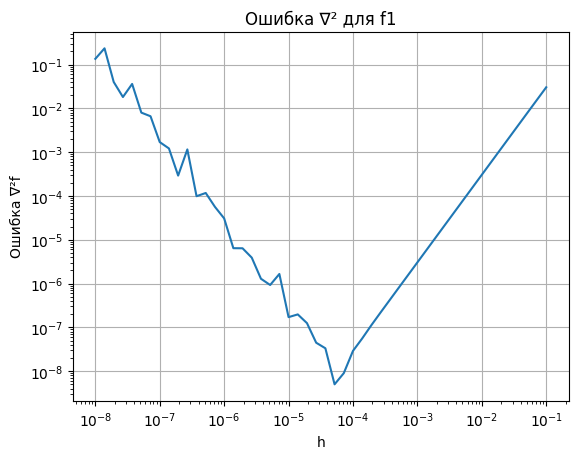

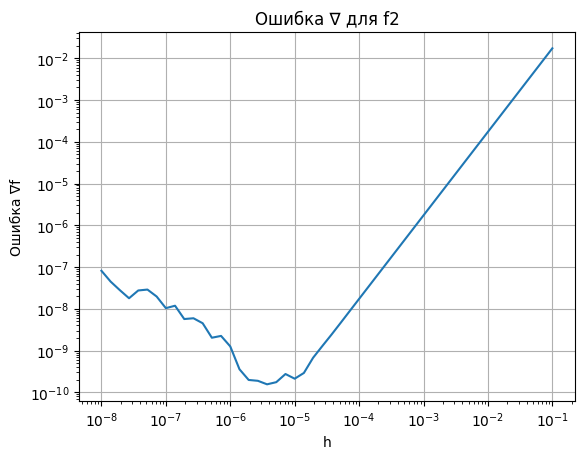

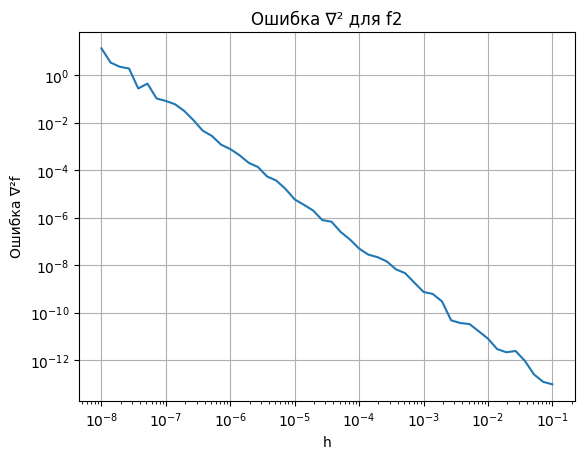

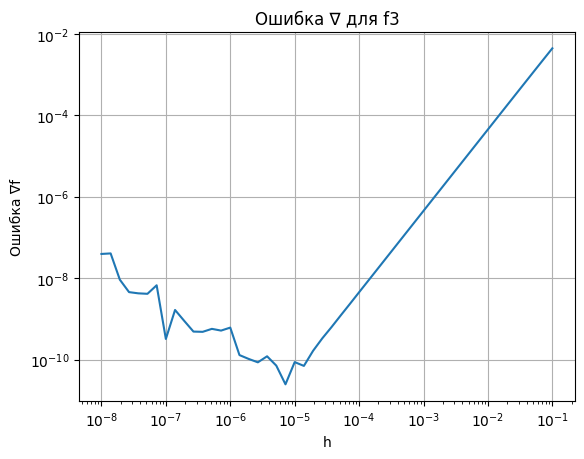

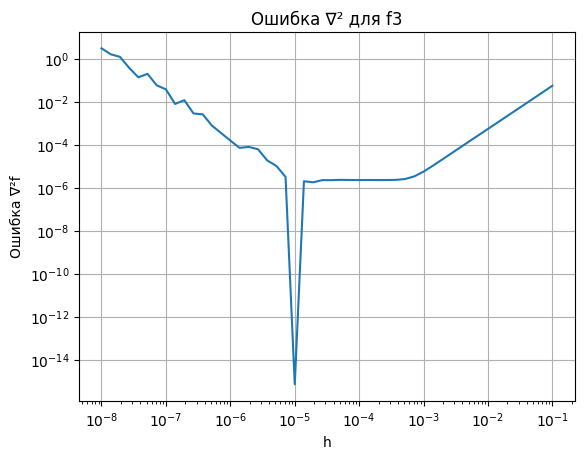

In [84]:
for name, (f, g_true, H_true, x0) in points.items():
    grad_err, hess_err = [], []
    for h in hs:
        grad_err.append(np.linalg.norm(numerical_gradient(f,x0,h) - g_true(x0)))
        hess_err.append(np.linalg.norm(numerical_hessian(f,x0,h) - H_true(x0)))
    plt.figure()
    plt.loglog(hs, grad_err)
    plt.xlabel('h')
    plt.ylabel('Ошибка ∇f')
    plt.title(f'Ошибка ∇ для {name}')
    plt.grid(True)
    plt.show()
    plt.figure()
    plt.loglog(hs, hess_err)
    plt.xlabel('h')
    plt.ylabel('Ошибка ∇²f')
    plt.title(f'Ошибка ∇² для {name}')
    plt.grid(True)
    plt.show()

#### Время вычисления градиента и гессиана при росте размерности

In [ ]:
def make_lin_function(n):
    def f(x): return np.dot(np.arange(1,n+1), x)
    return f

In [86]:
ns = np.arange(100, 1001, 100)
times_grad, times_hess = [], []
for n in ns:
    f_lin = make_lin_function(n)
    x = np.ones(n)
    t0 = time.time()
    numerical_gradient(f_lin, x)
    times_grad.append(time.time()-t0)
    t0 = time.time()
    numerical_hessian(f_lin, x)
    times_hess.append(time.time()-t0)

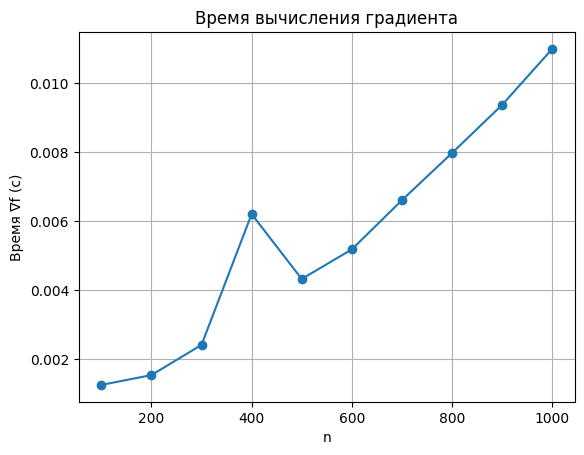

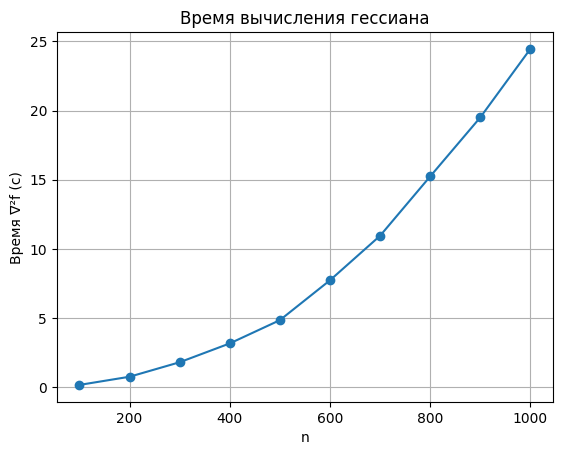

In [87]:
plt.figure()
plt.plot(ns, times_grad, marker='o')
plt.xlabel('n')
plt.ylabel('Время ∇f (с)')
plt.title('Время вычисления градиента')
plt.grid(True)
plt.show()
plt.figure()
plt.plot(ns, times_hess, marker='o')
plt.xlabel('n')
plt.ylabel('Время ∇²f (с)')
plt.title('Время вычисления гессиана')
plt.grid(True)
plt.show()

#### Реализация метода Ньютона (фиксированный α и адаптивный по Армихо–Вульфу)

In [88]:
def newton(f, grad, hess, x0, tol=1e-8, maxiter=50):
    x = x0.astype(float).copy()
    traj=[x.copy()]
    norms=[np.linalg.norm(grad(x))]
    for k in range(maxiter):
        g = grad(x)
        H = hess(x)
        p = np.linalg.solve(H, g)
        x -= p
        traj.append(x.copy())
        norms.append(np.linalg.norm(grad(x)))
        if norms[-1]<tol: break
    return traj, norms

In [89]:
def newton_armijo(f, grad, hess, x0, tol=1e-8, maxiter=50, c1=1e-4, rho=0.5):
    x = x0.astype(float).copy()
    traj=[x.copy()]
    norms=[np.linalg.norm(grad(x))]
    for k in range(maxiter):
        g = grad(x)
        H = hess(x)
        p = np.linalg.solve(H, g)
        alpha = 1.0
        fx = f(x)
        while f(x - alpha*p) > fx - c1*alpha*np.dot(g,p):
            alpha *= rho
        x -= alpha*p
        traj.append(x.copy())
        norms.append(np.linalg.norm(grad(x)))
        if norms[-1]<tol: break
    return traj, norms

#### Тест на квадратичной функции

In [90]:
A = np.array([[3,1],[1,2]])
b = np.array([-1,4])
def fq(x): return x.dot(A).dot(x) + b.dot(x)
def grad_q(x): return (A + A.T).dot(x) + b
def hess_q(x): return A + A.T

In [91]:
x0 = np.array([5.0, -3.0])
traj_f, norms_f = newton(fq, grad_q, hess_q, x0)
traj_a, norms_a = newton_armijo(fq, grad_q, hess_q, x0)

Сравнение сходимости

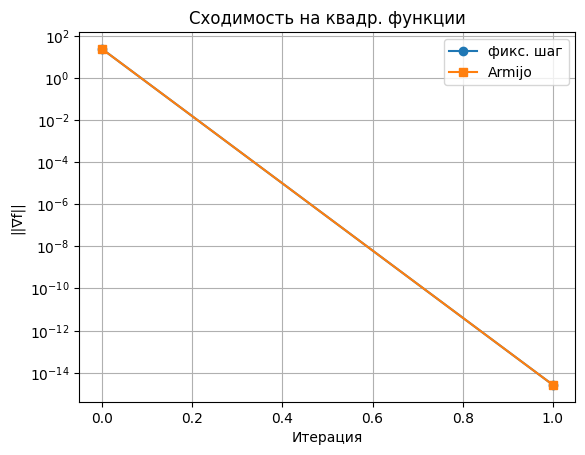

In [92]:
plt.figure()
plt.semilogy(norms_f, marker='o', label='фикс. шаг')
plt.semilogy(norms_a, marker='s', label='Armijo')
plt.xlabel('Итерация')
plt.ylabel('||∇f||')
plt.title('Сходимость на квадр. функции')
plt.legend()
plt.grid(True)
plt.show()

#### Функция пика: $\frac{-1}{1+(x-a)^2+(y-b)^2}$

In [93]:
team_ISU = np.array([368876, 368225, 470110, 867495])
a = hmean(team_ISU)/1e5
b = gmean(team_ISU)/1e5

In [94]:
def f_peak(x):
    return -1.0/(1 + (x[0]-a)**2 + (x[1]-b)**2)
def grad_peak(x): return numerical_gradient(f_peak, x)
def hess_peak(x): return numerical_hessian(f_peak, x)

Тестовые начальные точки

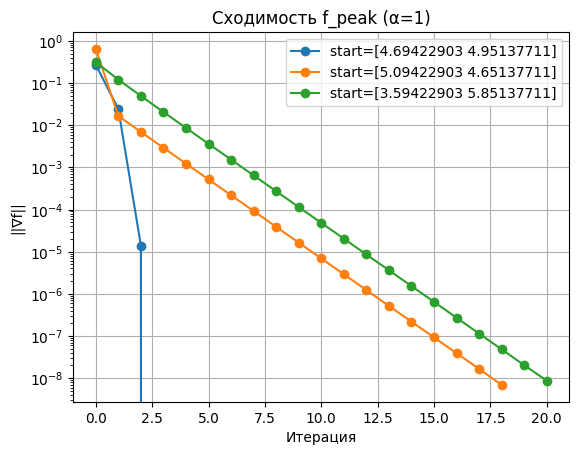

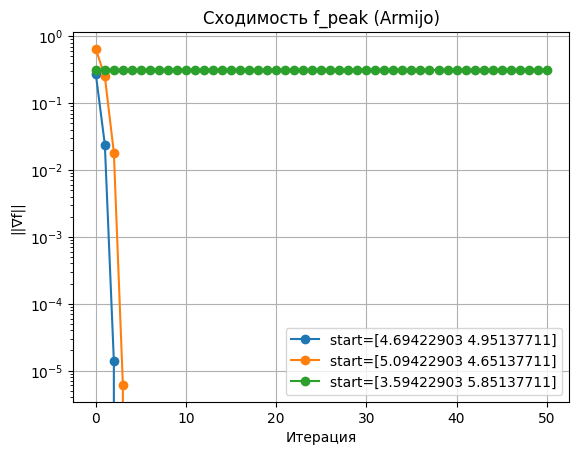

In [95]:
inits = [np.array([a+0.1, b+0.1]), np.array([a+0.5, b-0.2]), np.array([a-1.0, b+1.0])]
for alpha_name, method in [('α=1', newton), ('Armijo', newton_armijo)]:
    plt.figure()
    for x0 in inits:
        traj, norms = method(f_peak, grad_peak, hess_peak, x0)
        plt.semilogy(norms, marker='o', label=f'start={x0}')
    plt.xlabel('Итерация')
    plt.ylabel('||∇f||')
    plt.title(f'Сходимость f_peak ({alpha_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Логарифмическая функция и её область

In [96]:
def f_log(x):
    u,v = x
    return -9*u -10*v + 10*(-np.log(100-u-v) - np.log(u) - np.log(v) - np.log(50-u+v))
def grad_log(x): return numerical_gradient(f_log, x)
def hess_log(x): return numerical_hessian(f_log, x)

Область определения: $u>0, v>0, u+v<100, 50-u+v>0$

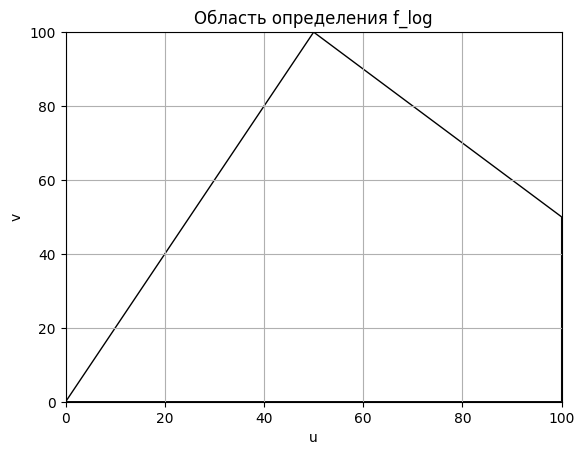

In [97]:
fig, ax = plt.subplots()
region = patches.Polygon([[0,0],[100,0],[100,50],[50,100],[0,0]], closed=True, fill=False)
ax.add_patch(region)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_title('Область определения f_log')
ax.set_xlabel('u')
ax.set_ylabel('v')
plt.grid(True)
plt.show()

Тест начальных точек

/tmp/ipykernel_126635/462032754.py:3: RuntimeWarning: invalid value encountered in log
  return -9*u -10*v + 10*(-np.log(100-u-v) - np.log(u) - np.log(v) - np.log(50-u+v))


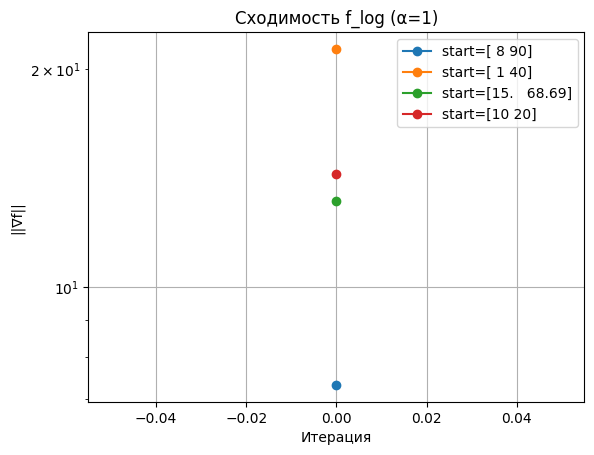

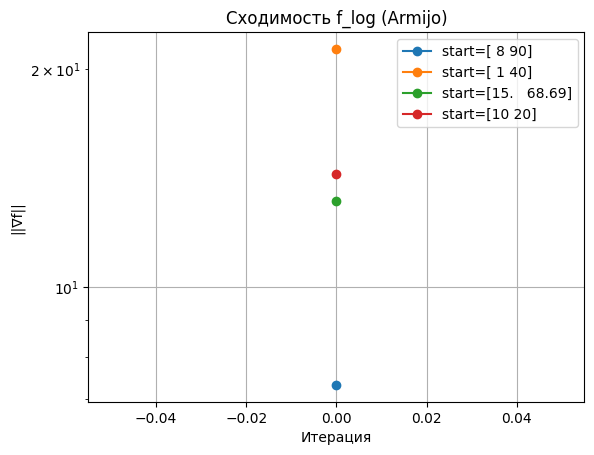

In [98]:
starts = [np.array([8,90]), np.array([1,40]), np.array([15,68.69]), np.array([10,20])]
for alpha_name, method in [('α=1', newton), ('Armijo', newton_armijo)]:
    plt.figure()
    for x0 in starts:
        traj, norms = method(f_log, grad_log, hess_log, x0)
        plt.semilogy(norms, marker='o', label=f'start={x0}')
    plt.xlabel('Итерация')
    plt.ylabel('||∇f||')
    plt.title(f'Сходимость f_log ({alpha_name})')
    plt.legend()
    plt.grid(True)
    plt.show()